In [1]:
%matplotlib inline
import gym
import numpy as np
from collections import defaultdict 
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
import math
import sys, traceback
import logging
import pickle
import copy
from sklearn import linear_model
import tensorflow as tf

/Users/asvenk/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger()
Q = defaultdict(dict)
Observed_Counts = defaultdict(dict)
ALPHA = 0.1
GAMMA = 0.9
NO_OF_EPISODES = 500
NO_OF_ITER = 200
ANGLE_TILE_SIZE = 18 # Should be such that no bin lies on both sides of center
THETADOT_TILE_SIZE = 6
# ACTIONS = [-2, -1.6, -0.8, -0.4, -0.2, 0, 0.2, 0.4, 0.8, 1.6, 2]
ACTIONS = [-1.5, -0.1, 0, 0.1, 1.5 ]
MAX_LENGTH_MEMORY = 10000
REPLAY_SAMPLE_SIZE = 50
ENABLE_REPLAY = False
DEBUG = False
replay_memory = []
filename = str(NO_OF_EPISODES) + '_' + str(NO_OF_ITER) + '_' + str(MAX_LENGTH_MEMORY) + '_' + str(REPLAY_SAMPLE_SIZE)
current_session = None

In [3]:
# Credits: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/multilayer_perceptron.ipynb
# Parameters
learning_rate = 0.001
training_epochs = 1
batch_size = 100
display_step = 1

# Network Parameters
n_hidden_1 = 5 # 1st layer number of features
n_hidden_2 = 5 # 2nd layer number of features
n_input = 3 # State and action
n_classes = 1 # Reward

# Memory for storing rewards obtained
reward_memory = []
MIN_OBSERVE_LEN = 5000

In [4]:
thetadot_bin = {}
def epsilon_greedy(state, epsilon):
    # print state
    valid_actions = Q[state].keys()
    if np.random.random() < epsilon:
        return np.random.choice(ACTIONS)
    max_action = max(Q[state], key=Q[state].get)
    return max_action

def set_thetadot_bins():
    thetadot_bin[1] = (0, 0.5)
    thetadot_bin[-1] = (-0.5, 0)
    thetadot_bin[2] = (0.5, 1.5)
    thetadot_bin[3] = (1.5, 2.5)
    thetadot_bin[4] = (2.5, 3.5)
    thetadot_bin[5] = (3.5, 4.5)
    thetadot_bin[6] = (4.5, 5.5)
    thetadot_bin[7] = (5.5, 6.5)
    thetadot_bin[8] = (6.5, 8.1)
    
    thetadot_bin[-2] = (-1.5, -0.5)
    thetadot_bin[-3] = (-2.5, -1.5)
    thetadot_bin[-4] = (-3.5, -2.5)
    thetadot_bin[-5] = (-4.5, -3.5)
    thetadot_bin[-6] = (-5.5, -4.5)
    thetadot_bin[-7] = (-6.5, -5.5)
    thetadot_bin[-8] = (-8.1, -6.5)

def set_theta_bins():
    theta_bin[0] = [(0,10), (350,360)]
    theta_bin[1] = [(10,30)]
    theta_bin[2] = [(30,50)]
    theta_bin[3] = [(50,70)]
    theta_bin[4] = [(70,90)]
    theta_bin[5] = [(90,110)]
    theta_bin[6] = [(110,130)]
    theta_bin[7] = [(130,150)]
    theta_bin[8] = [(150,170)]
    theta_bin[9] = [(170,190)]
    theta_bin[10] = [(190,210)]
    theta_bin[11] = [(210,230)]
    theta_bin[12] = [(230,250)]
    theta_bin[13] = [(250,270)]
    theta_bin[14] = [(270,290)]
    theta_bin[15] = [(290,310)]
    theta_bin[16] = [(310,330)]
    theta_bin[17] = [(330,350)]    

set_thetadot_bins()

def get_theta_bin(angle):
    bin_num = int(angle/ANGLE_TILE_SIZE)
    return bin_num
    
def get_thetadot_bin(i):
    for key in thetadot_bin:
        if i > thetadot_bin[key][0] and i <= thetadot_bin[key][1]:
            return key
    raise "Key not found for %s"%(i)

def get_discrete_state(S):
    theta = get_theta_bin((math.degrees(normalize_angle_360(S[0])))) 
    thetadot = get_thetadot_bin(S[1])
    return (theta, thetadot)

def normalize_angle_180(x):
    x = (x % (2*np.pi))
    if x < 0:
        x = ( x + (2*np.pi))
    if x >=0 and x <=180:
        return x
    else:
        return x - 360

def normalize_angle_360(x):
    x = (x % (2*np.pi))
    if x < 0:
        return ( x + (2*np.pi))
    return x
    
def init_Q():
    angle_incr_step = (1.8/(180/ANGLE_TILE_SIZE))
    for theta in range(0, 360/ANGLE_TILE_SIZE):
        for thetadot in thetadot_bin.keys():
            for action in ACTIONS:
                if theta > 180:
                    Q[(theta, thetadot)][action] = 0.2 + (angle_incr_step * (360 - theta))
                else:
                    Q[(theta, thetadot)][action] = -(0.2 + (angle_incr_step * (theta)))
                Observed_Counts[(theta, thetadot, action)] = 0

In [ ]:
# Credits: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/mnist/mnist_with_summaries.py
# We can't initialize these variables to 0 - the network will get stuck.
def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.scalar_summary('stddev', stddev)
        tf.scalar_summary('max', tf.reduce_max(var))
        tf.scalar_summary('min', tf.reduce_min(var))
        tf.histogram_summary('histogram', var)

def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    """Reusable code for making a simple neural net layer.
    It does a matrix multiply, bias add, and then uses relu to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
    with tf.name_scope('weights'):
        weights = weight_variable([input_dim, output_dim])
        variable_summaries(weights)
    with tf.name_scope('biases'):
        biases = bias_variable([output_dim])
        variable_summaries(biases)
    with tf.name_scope('Wx_plus_b'):
        preactivate = tf.matmul(input_tensor, weights) + biases
        tf.summary.histogram('pre_activations', preactivate)
    if act is not None:
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
        return activations
    return activations

def build_model_graph():
    # tf Graph input
    x = tf.placeholder(tf.float32, [None, n_input], name='X')
    
    # Linear Network
    layer1 = nn_layer(x, n_input, n_hidden1, 'L1', act=None)
    print layer1
    layer2 = nn_layer(x, n_hidden1, n_hidden2, 'L2', act=None)
    print layer2
    y_pred = nn_layer(x, n_hidden3, 1, 'YPred', act=None)
    print y_pred
    
    # Loss
    y = tf.placeholder(tf.float32, [None, n_classes])
    y_diff = tf.sub(y, y_pred, name='YDiff')
    loss = tf.reduce_sum(tf.square(y_diff), name='Loss')
    print loss
    
    # Optimizer node
    with tf.name_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # Summary node
    with tf.name_scope('Summaries'):
        # Create a summary to monitor cost tensor
        tf.scalar_summary("loss", loss)
        # Merge all summaries into a single op
        summary = tf.merge_all_summaries()
    
    return y_pred, loss, optimizer, summary

In [5]:
# Credits: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/multilayer_perceptron.ipynb
# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [6]:
def train_model(batch_x, batch_y):
    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    # Construct model
    pred = multilayer_perceptron(x, weights, biases)

    # Define loss and optimizer
    # Mean squared error
    cost = tf.reduce_sum(tf.pow(pred, 2))/(2*len(batch_x))
    # Gradient descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
#     cost = tf.reduce_mean(tf.nn.l2_loss(pred, y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
        # Compute average loss
        # Display logs per epoch step
#         if epoch % display_step == 0:
#             print "Epoch:", '%04d' % (epoch+1), "cost=", \
#                 "{:.9f}".format(c)
#     print "Optimization Finished!"
    current_session = sess
    return current_session, pred

def update_model():
    minibatch = random.sample(reward_memory, MIN_OBSERVE_LEN)
    X, y = [], []
    for reward_sample in reward_memory:
        X.append(reward_sample[:-1])
        y.append(reward_sample[-1])
    X = np.array(X)
    y = np.array(y).reshape(len(y), 1)
    return train_model(X, y)

def predict_reward(state, current_session, pred_model):
    reward = current_session.run(pred_model, feed_dict={x: [state]})
#     print 'State : %s, Action Predicted: %s'%(state, reward[0][0])
    return reward[0][0] 

In [7]:
def qlearning_decay(env_name, ep):
    env = gym.make(env_name)
    init_Q()
    episode_rewards = []
    observed_theta, observed_thetadot = [], []
    all_observed_theta, all_observed_thetadot = [], []
    td_error_all = []
    epsilon = ep
    current_session = None
    for i in range(NO_OF_EPISODES):
#         if i % 100 == 0:
        print 'Episode %d'%(i)
        total_episode_reward = 0
        S = env.reset()
        discrete_S = get_discrete_state(S)
        for t in range(NO_OF_ITER):
            A = epsilon_greedy(discrete_S, epsilon)
            S_next, reward, _, _ = env.step([A])
            if reward == 0: # Did not receive the reward for this time step.
                if len(reward_memory) < int(MIN_OBSERVE_LEN): # Check what should be done here ?
                    continue
                if current_session is None:
                    current_session, pred_model = update_model()
                if current_session != None:
                    reward = predict_reward(np.array([S[0], S[1], A]), current_session, pred_model)
            else:
                reward_memory.append(np.array([S[0], S[1], A, reward]))
            total_episode_reward += reward
            discrete_S_next = get_discrete_state(S_next)
            A_next = max(Q[discrete_S_next], key=Q[discrete_S_next].get)
            # Update the Q values
            td_error = reward + GAMMA*Q[discrete_S_next][A_next] - Q[discrete_S][A]
            td_error_all.append(td_error**2)
            Q[discrete_S][A] = Q[discrete_S][A] + ALPHA*(td_error)
            discrete_S = discrete_S_next
        episode_rewards.append(total_episode_reward)
        if len(reward_memory) >= int(MIN_OBSERVE_LEN):
#             print 'Updating the model'
            current_session, pred = update_model()
        if i > 1000:
            epsilon -= (1/i)
    print 'Observed rewards in %d steps out of %d steps'%(len(reward_memory), (NO_OF_EPISODES*NO_OF_ITER))
    return episode_rewards, td_error_all

In [8]:
episode_rewards, td_error_all = qlearning_decay('SemisuperPendulumRandom-v0', 0.2)

[2016-11-25 15:04:48,502] Making new env: SemisuperPendulumRandom-v0


Action Space
Box(1,)
Observation Space
Box(3,)
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Episod

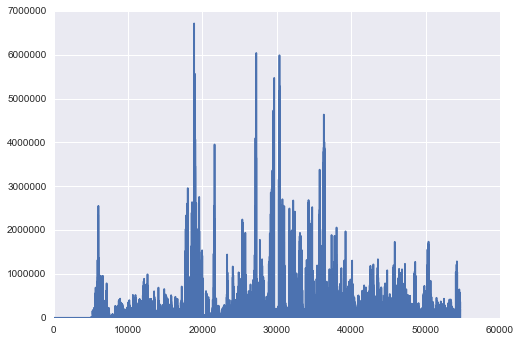

In [11]:
plt.plot(re)